# Exercise 6

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint, chi2

## Implementation of Metropolis-Hastings

Before solving the concrete exercises, we implement the Metropolis-Hastings algorithm:

In [100]:
def metropolis_hastings(target_dist_pdf, proposal_dist_pdf, proposal_dist_rvs, initial_value, N):
    samples = np.empty(N + 1)
    samples[0] = initial_value
    accepted = np.empty(N + 1)
    accepted[0] = True

    for n in range(1, N + 1):
        proposed_val = samples[n - 1] + proposal_dist_rvs()

        p_accept = min(1, target_dist_pdf(proposed_val) / target_dist_pdf(samples[n - 1]))

        if uniform.rvs() < p_accept:
            samples[n] = proposed_val
            accepted[n] = True
        else:
            samples[n] = samples[n - 1]
            accepted[n] = False

    return samples[1:], accepted[1:]

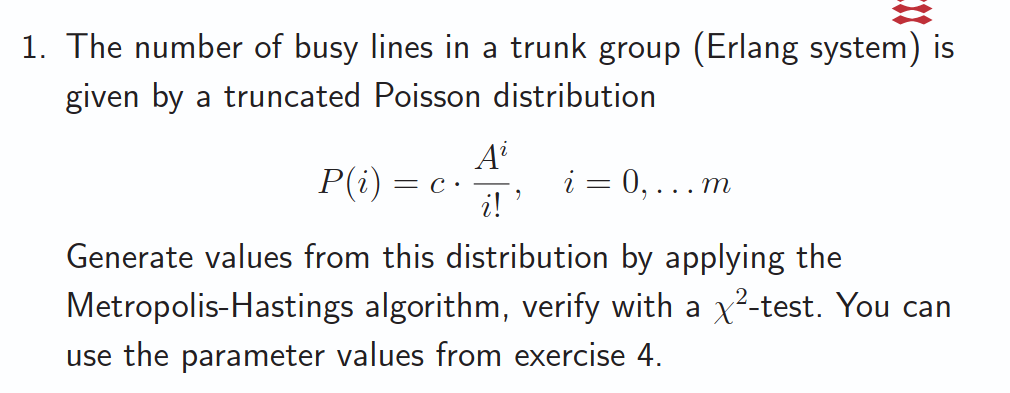

First we implement a random walk distribution, that generates values of +/- 1 with equal probability:

In [101]:
class RW:
    def rvs(self):
        if uniform.rvs() < 0.5:
            return -1
        return 1
    
    def pdf(self, x, y):
        if abs(x - y) == 1:
            return 0.5
        return 0

proposal_dist = RW()

We then run the Metropolis-Hastings algorithm with the given target distribution, and our random walk proposal distribution. For debug purposes, we log the acceptance rate:

In [105]:
m = 10

def factorial(n):
    if n in [0, 1]:
        return 1
    return n * factorial(n - 1)

# from exercise definition
def target_dist_pmf(i):
    if i < 0 or m < i:
        return 0
    A = 8
    return A**i / factorial(i)

N = 10_000

samples, accepted = metropolis_hastings(target_dist_pmf, proposal_dist.pdf, proposal_dist.rvs, initial_value=5, N=N)

print("Acceptance rate:", np.mean(accepted))


Acceptance rate: 0.8219


We then plot the sample distribution along with the target distribution:

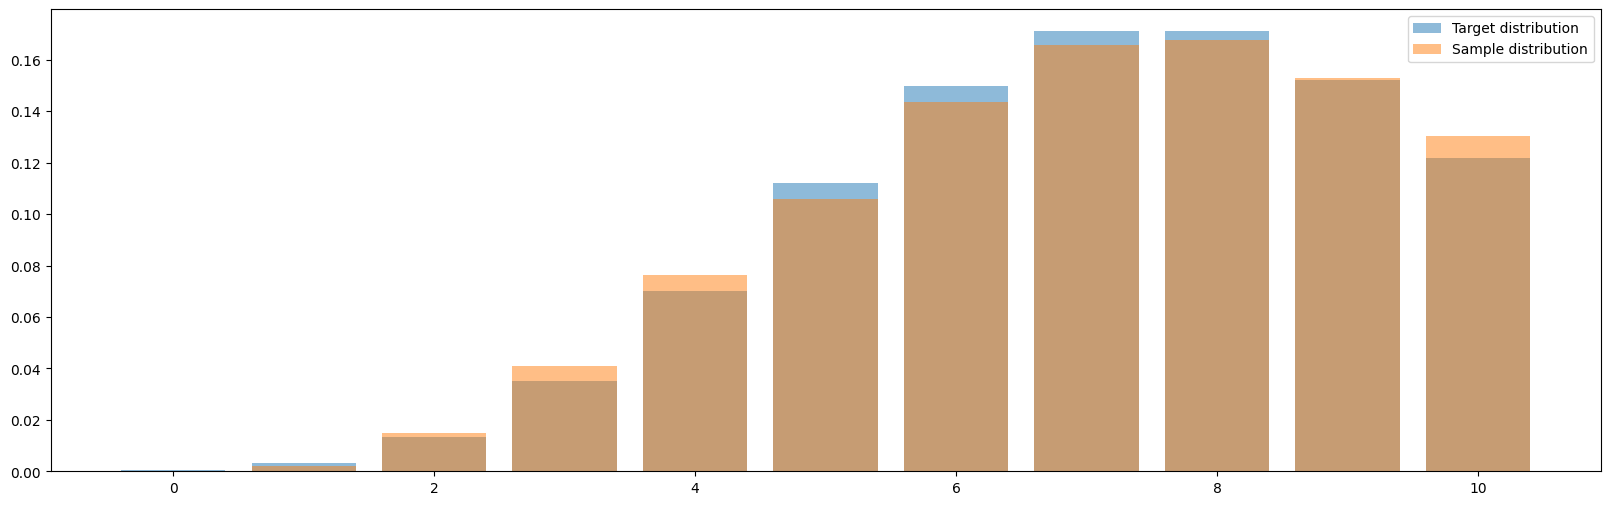

In [106]:
idx, c = np.unique(samples[N // 2:], return_counts=True)

counts = np.zeros(m + 1)
counts[idx.astype(int)] = c
counts /= np.sum(counts)

xs = np.arange(m + 1)
pi = np.array([target_dist_pmf(i) for i in xs])
pi /= np.sum(pi)

fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

ax1.bar(xs, pi, alpha=0.5, label="Target distribution")
ax1.bar(xs, counts, alpha=0.5, label="Sample distribution")
ax1.legend()
plt.show()

To test how well we've approximated the target distribution, we perform a chi-squared test:

In [107]:
def chi2_test(samples, ps):

    idx, counts = np.unique(samples, return_counts=True)

    n = np.zeros_like(ps)
    n[idx.astype(int)] = counts

    n_exp = ps * np.sum(n)

    T = np.sum((n - n_exp)** 2 / n_exp)

    # test stat follows chi2(k - 1), week 1 slide 10
    return 1 - chi2.cdf(T, len(ps) - 1)


print("P-value:", chi2_test(samples[N // 2:], pi))

P-value: 0.03460902045641656


We observe a low p-value, which for one sample could be grounds for concern. To test the algorithm further, we draw 100 samples of size $N=500$, and test the distribution of the last $250$ samples (meaning we discard $50\%$ of samples as warmup):

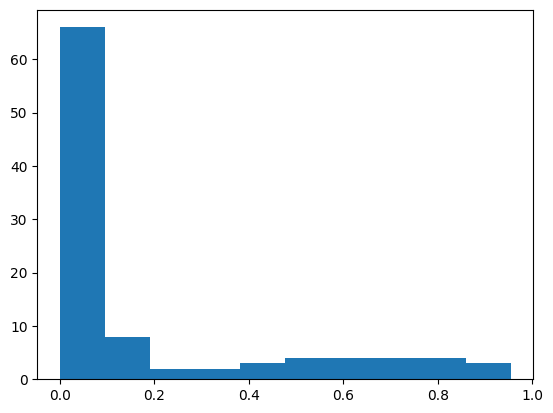

In [ ]:
p_vals = np.empty(100)
for i in range(100):
    samples, accepted = metropolis_hastings(target_dist_pmf, proposal_dist.pdf, proposal_dist.rvs, initial_value=5, N=500)
    p_vals[i] = chi2_test(samples[250:], pi)

plt.hist(p_vals)
plt.show()

The p-values are heavily biased towards low values, which suggests that we are not approximating the target distribution very well. Whether this is because of implementation errors or the inherent correlation between samples in MCMC, is unclear.

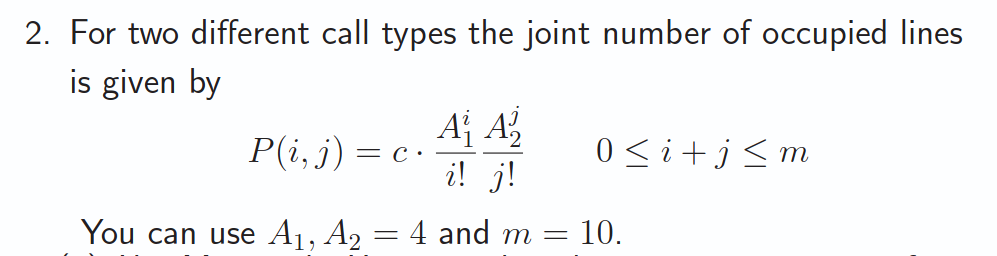

We implement our new target distribution:

In [ ]:
def target_dist_pmf(i, j):
    A1 = 4
    A2 = 4
    if 0 <= i <= m and 0 <= j <= m and i + j <= m:
        return (A1**i / factorial(i)) * (A2**j / factorial(j))
    return 0


class RW2D:
    def rvs(self):
        di, dj = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1])
        return di, dj
    
    def pdf(self, x, y):
        xx, xy = x
        if abs(x - y) == 1:
            return 0.5
        return 0

proposal_dist = RW()